In [161]:
import os
import cv2
import random
import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import sys # to check the version of Python

# scikit learn modules for model confusion matrix evaluation
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from keras import backend as K #for clearing out Tensorflow memory resources
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import mixed_precision
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.preprocessing.image import load_img

# Loading data sets
from keras.utils import image_dataset_from_directory

# Callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import ModelCheckpoint, TensorBoard

# Transfer Learning models
from keras.applications.vgg19 import VGG19
from keras.applications.efficientnet_v2 import EfficientNetV2S

# Model layers
from keras.models import Sequential
from keras.layers import Input, Rescaling, RandomRotation, RandomTranslation, RandomContrast
from keras.layers import RandomFlip, Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Dropout, Flatten, Dense

In [162]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dougandrade/dog-emotions-5-classes")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/dougandrade/dog-emotions-5-classes/versions/1


In [163]:
seed        = 42
img_dir = path+'/train_images_5_class'
img_size    = 224
batch_size  = 128

In [164]:
ds_train = image_dataset_from_directory(
    directory = img_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['alert', 'angry', 'frown', 'happy', 'relax'],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_size, img_size),
    shuffle = True,
    validation_split = 0.25,  # Split 25% of the data for validation
    subset = 'training',
    seed = 42
)

Found 9325 files belonging to 5 classes.
Using 6994 files for training.


In [165]:
ds_val = image_dataset_from_directory(
    directory = img_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['alert', 'angry', 'frown', 'happy', 'relax'],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_size, img_size),
    shuffle = True,
    validation_split = 0.25,  # Split 25% of the data for validation
    subset = 'validation',
    seed = 42
)

Found 9325 files belonging to 5 classes.
Using 2331 files for validation.


In [166]:
class_names = ['alert', 'angry', 'frown', 'happy', 'relax']
for image_batch, labels_batch in ds_train:
  print('Image shape: ', image_batch.shape)
  print('Label shape: ', labels_batch.shape)
  print('Label names: ', class_names)
  break

Image shape:  (128, 224, 224, 3)
Label shape:  (128, 5)
Label names:  ['alert', 'angry', 'frown', 'happy', 'relax']


In [167]:
for class_name in class_names:
    class_path = os.path.join(img_dir, class_name)
    if os.path.isdir(class_path):
        file_count = len(os.listdir(class_path))
        print(f'Total files in {class_name}: {file_count}')

Total files in alert: 1865
Total files in angry: 1865
Total files in frown: 1865
Total files in happy: 1865
Total files in relax: 1865


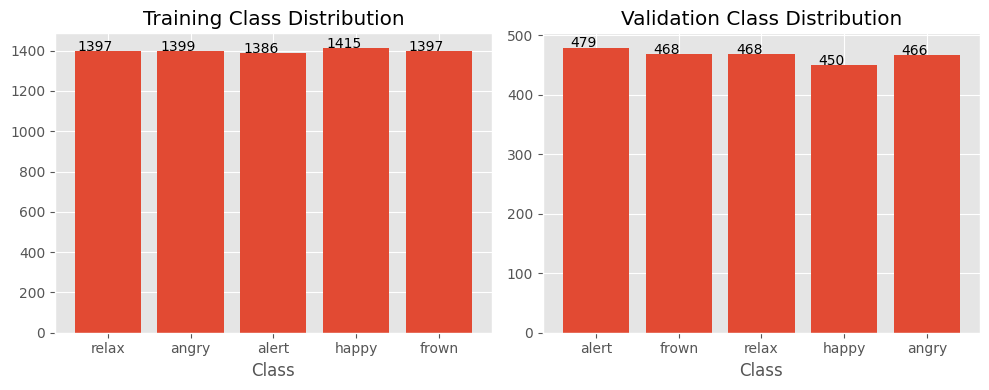

In [168]:
# Function to count class distribution
def class_distribution(dataset, class_names):
    #global class_counts
    class_counts = {}
    for _, labels_batch in dataset:
        for label in labels_batch.numpy():
            class_name = class_names[label.argmax()]  # Convert one-hot encoded label to class name
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Function to plot the class distribution
def plot_class_distribution(dataset, class_names):
    class_counts = class_distribution(dataset, class_names)

    #fig, ax = plt.subplots()
    bars = plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    #plt.ylabel('Count')
    plt.title('Image Class Distribution')

    # Add class count as text overlay on each bar
    for bar, value in zip(bars, class_counts.values()):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15,
                 bar.get_height() + 0.2,
                 str(value),
                 ha = 'center',
                 color = 'black')
    plt.tight_layout()

# Plot the class distribution for the training dataset
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plot_class_distribution(ds_train, class_names)
plt.title('Training Class Distribution')

# Plot the validation class distribuition
plt.subplot(1, 2, 2)
plot_class_distribution(ds_val, class_names)
plt.title('Validation Class Distribution')

plt.tight_layout()
plt.show()

<ipython-input-169-2ba356d1d604>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(ds_train.class_names[int(tf.where(labels[i] == 1).numpy())])


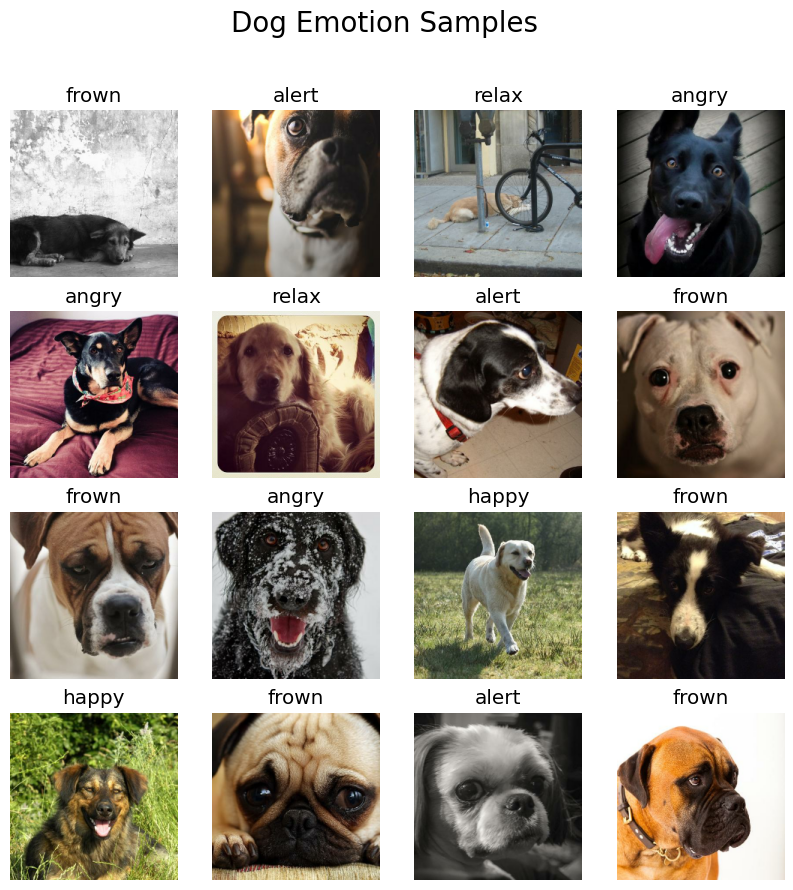

In [169]:
plt.figure(figsize = (10, 10))
for images, labels in ds_train.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(ds_train.class_names[int(tf.where(labels[i] == 1).numpy())])
    plt.suptitle('Dog Emotion Samples', fontsize = 20)
    plt.axis("off")

In [170]:
# Define the transfer learning model for emotion classification
tl_model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
)

# Freeze the base_model
tl_model.trainable = False

# Image Augmentation Layer
img_aug_layer = Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(
        factor=0.25,
        fill_mode='constant',
        fill_value=0.0,
        interpolation='bilinear'
    ),
    RandomTranslation(
        height_factor=0.1,
        width_factor=0.1,
        fill_mode='constant',
        fill_value=0.0
    ),
    RandomContrast(factor=0.25),
], name='Image_Augmentation')

# Top Dense Layers
top_FC_layer = Sequential([
    Dense(units=256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(units=1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
], name='Top_Dense_Layers')

# Combined Model for Emotion Classification
emotion_model = Sequential(name='Emotion_Classification_Model')

# Add layers to the model
emotion_model.add(Input(shape=(img_size, img_size, 3)))  # Input layer
emotion_model.add(img_aug_layer)  # Image augmentation
emotion_model.add(tl_model)  # Transfer learning backbone
emotion_model.add(Flatten(name='Flatten_Layer'))  # Flatten the output
emotion_model.add(top_FC_layer)  # Top fully connected layers
emotion_model.add(Dense(units=len(class_names),  # Multi-class output layer
                        activation='softmax',
                        dtype='float32',
                        name='Multi-Class_Output'))

emotion_model.summary()

Model: "Emotion_Classification_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Image_Augmentation (Sequential)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 7, 7, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Top_Dense_Layers (Sequential)        │ (None, 1024)                │      16,720,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Multi-Class_Output (Dense)           │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,057,125 (141.36 MB)

 Trainable params: 16,722,181 (63.79 MB)

 Non-trainable params: 20,334,944 (77.57 MB)

In [171]:
emotion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint(
    'dog_emotion_model.keras',  # Save the best model
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [172]:
# Train the model
history = emotion_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=60,
    batch_size=batch_size,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2282 - loss: 2.5557
Epoch 1: val_accuracy improved from -inf to 0.32390, saving model to dog_emotion_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 264ms/step - accuracy: 0.2286 - loss: 2.5534 - val_accuracy: 0.3239 - val_loss: 1.7771 - learning_rate: 0.0010
Epoch 2/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2864 - loss: 2.0877
Epoch 2: val_accuracy improved from 0.32390 to 0.36293, saving model to dog_emotion_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.2866 - loss: 2.0868 - val_accuracy: 0.3629 - val_loss: 1.5290 - learning_rate: 0.0010
Epoch 3/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3349 - loss: 1.8138
Epoch 3: val_accuracy improved from 0.36293 to 0.42299, saving model to dog_emotion_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.3351 - loss: 1.8132 - val_accuracy: 0.4230 - val_loss: 1.3874 - learning_rate: 0.0010
Epoch 4/60
55/55 ━━━━━━━━━━━━━━

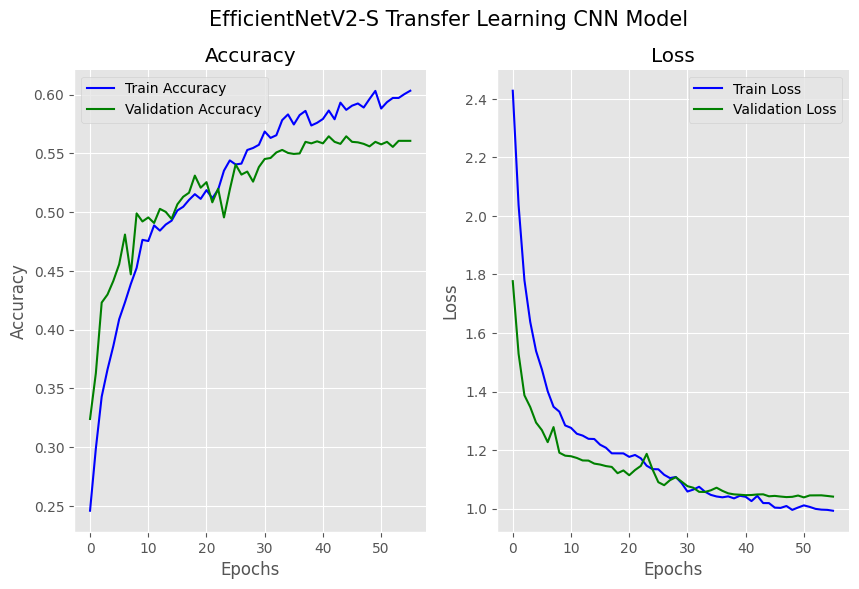

In [173]:
# Collect training and validation metric data from the model training
acc        = history.history['accuracy']
val_acc    = history.history['val_accuracy']
loss       = history.history['loss']
val_loss   = history.history['val_loss']
num_epochs = range(len(acc))

# Plot the Training and Test accuracy over all the epochs
fig1, ax1 = plt.subplots(1, 2, figsize = (10, 6))
fig1.suptitle('EfficientNetV2-S Transfer Learning CNN Model', c = 'k', fontsize = '15')

ax1[0].plot(acc, 'b-', label = 'Train Accuracy')
ax1[0].plot(val_acc, 'g-', label = 'Validation Accuracy')
ax1[0].set_title('Accuracy')
ax1[0].legend()
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Accuracy')
ax1[0].spines['right'].set_visible(False)
ax1[0].spines['top'].set_visible(False)

ax1[1].plot(loss, 'b-', label = 'Train Loss')
ax1[1].plot(val_loss, 'g-', label = 'Validation Loss')
ax1[1].set_title('Loss')
ax1[1].legend()
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
ax1[1].spines['right'].set_visible(False)
ax1[1].spines['top'].set_visible(False)

#ax1[2].plot(f1, 'b-', label = 'Train F1 Score')
#ax1[2].plot(val_f1, 'g-', label = 'Validation F1 Score')
#ax1[2].set_title('F1 Score')
#ax1[2].legend()
#ax1[2].set_xlabel('Epochs')
#ax1[2].set_ylabel('F1 Score')
#ax1[2].spines['right'].set_visible(False)
#ax1[2].spines['top'].set_visible(False)

plt.show()
#fig1.savefig('Model_plot_tl.jpg')

In [174]:
emotion_model.save('emotion_model.keras')

In [175]:
#emotion_model.save_weights('Emotion_model_weights.weights.h5')

In [176]:
model1 = keras.models.load_model('emotion_model.keras')

In [177]:
print("Standalone Keras Version:", keras.__version__)
print("TensorFlow Keras Version:", tf.keras.__version__)
print("TensorFlow Version:", tf.__version__)

Standalone Keras Version: 3.5.0
TensorFlow Keras Version: 3.5.0
TensorFlow Version: 2.17.1
